In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
#PyTorch
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# Prepare paths of input images and target segmentation masks
left_input_dir = "./output_images/output/left/"
right_input_dir = "./output_images/output/right/"
depth_dir = "./output_images/depth"

img_size = (320, 320)          #This is the biggest image I could get
num_classes = 4
batch_size = 16                # Bigger sizes sometimes couse crashes due to low memory
lower_color_threshold = 100


# Sorting image names in left input folder
left_input_img_paths = sorted([
    os.path.join(left_input_dir, fname)
    for fname in os.listdir(left_input_dir)
    if fname.endswith(".jpg")
])

# Sorting image names in left input folder
right_input_img_paths = sorted([
    os.path.join(right_input_dir, fname)
    for fname in os.listdir(right_input_dir)
    if fname.endswith(".jpg")
])

# Sorting image names in target folder
target_img_paths = sorted([
    os.path.join(depth_dir, fname)
    for fname in os.listdir(depth_dir)
    if fname.endswith(".jpg")
])

print("Number of left input samples:", len(left_input_img_paths))
print("Number of right input samples:", len(right_input_img_paths))
print("Number of target samples:", len(target_img_paths))

#Input and target images are now corresponding
for input_path, target_path in zip(left_input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of left input samples: 1119
Number of right input samples: 1119
Number of target samples: 1120
./output_images/output/left/image_depth_1701624237_257517568.jpg | ./output_images/depth/image_depth_1701624237_257517568.jpg
./output_images/output/left/image_depth_1701624238_197022720.jpg | ./output_images/depth/image_depth_1701624238_197022720.jpg
./output_images/output/left/image_depth_1701624238_857298688.jpg | ./output_images/depth/image_depth_1701624238_857298688.jpg
./output_images/output/left/image_depth_1701624239_787462144.jpg | ./output_images/depth/image_depth_1701624239_787462144.jpg
./output_images/output/left/image_depth_1701624240_603289856.jpg | ./output_images/depth/image_depth_1701624240_603289856.jpg
./output_images/output/left/image_depth_1701624241_240535808.jpg | ./output_images/depth/image_depth_1701624241_240535808.jpg
./output_images/output/left/image_depth_1701624241_954830080.jpg | ./output_images/depth/image_depth_1701624241_954830080.jpg
./output_images/

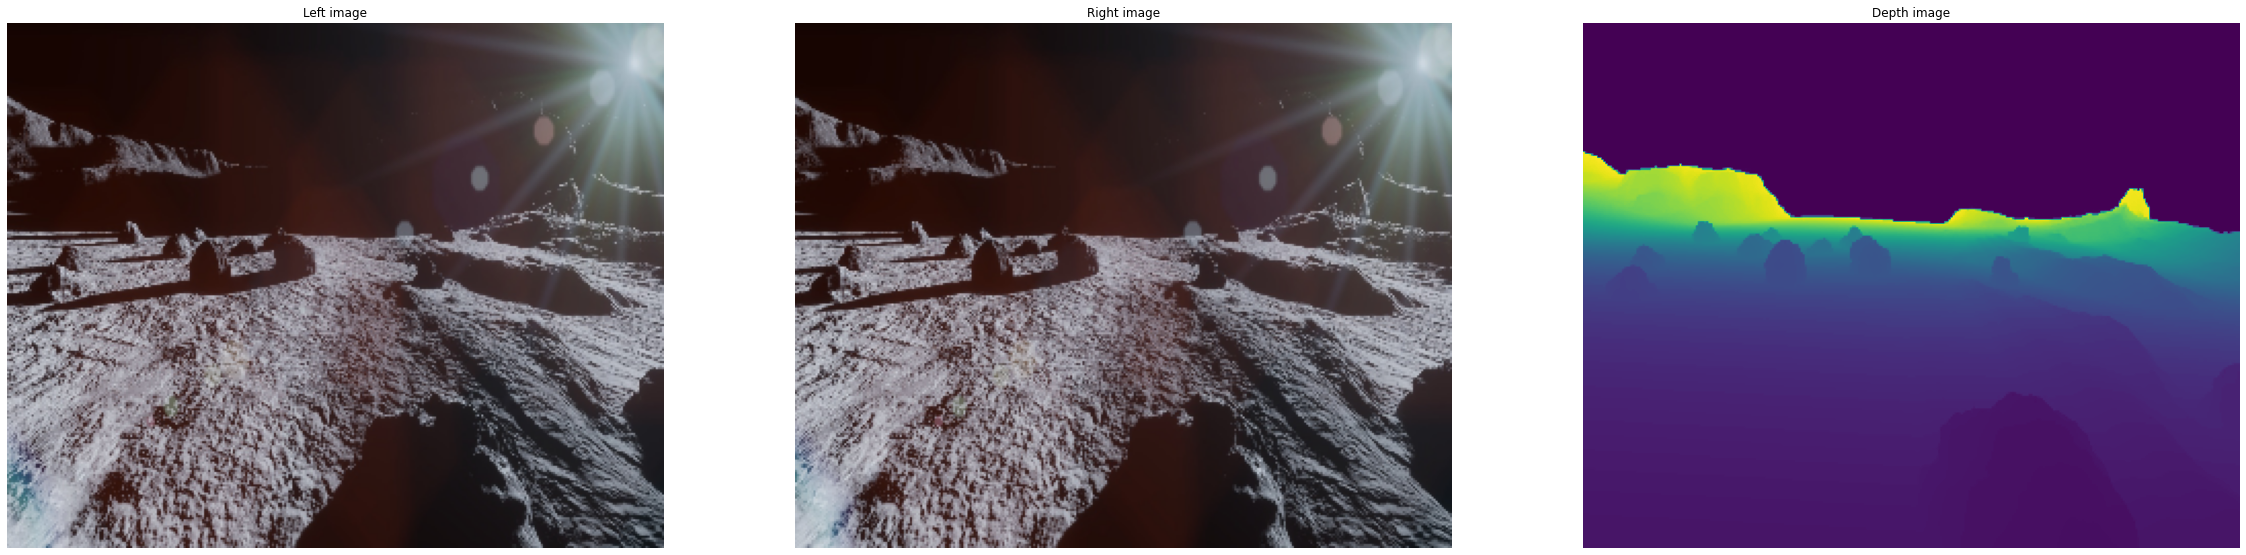

In [4]:
def load_image(path, size):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

def load_ground(path_size):
    img = cv2.imread(path)
    (R, G, B) = cv2.split(ground_img)

fig, axes = plt.subplots(1, 3, figsize=(40, 20))

index = 100
input_size= (320, 256)

# Assuming there are exactly three images
axes[0].imshow(load_image(left_input_img_paths[index], input_size))
axes[0].set_title("Left image")
axes[0].axis('off')

axes[1].imshow(load_image(right_input_img_paths[index], input_size))
axes[1].set_title("Right image")
axes[1].axis('off')

axes[2].imshow(load_image(target_img_paths[index], input_size)[:, :, 0])
axes[2].set_title("Depth image")
axes[2].axis('off')

plt.show()

In [5]:

class LunarStereoData(Dataset):
    
    def __init__(self, input_left_paths, input_right_paths, target_paths, img_size, batch_size):
        self.left_img_paths = input_left_paths
        self.right_img_paths = input_right_paths
        self.target_paths = target_paths
        self.img_size = img_size
        self.batch_size = batch_size

    def read_img(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        img = np.moveaxis(img, -1, 0)
        return img
        
    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = (idx + 1) * self.batch_size

        left_imgs = [self.read_img(self.left_img_paths[i]) for i in range(start_idx, end_idx)]
        right_imgs = [self.read_img(self.right_img_paths[i]) for i in range(start_idx, end_idx)]
        targets = [self.read_img(self.target_paths[i]) for i in range(start_idx, end_idx)]

        # convert lists to numpy arrays
        left_imgs = np.array(left_imgs)
        right_imgs = np.array(right_imgs)
        
        
        # Extract only the first channel from targets
        targets = [t[0, :, :] for t in targets]
        # targets = [np.expand_dims(t, axis=0) for t in targets]
        targets = np.array(targets)
        
        left_imgs = torch.tensor(left_imgs).type(torch.FloatTensor)
        right_imgs = torch.tensor(right_imgs).type(torch.FloatTensor)
        targets = torch.tensor(targets).type(torch.FloatTensor)

        return left_imgs, right_imgs, targets
        
    def __len__(self):
        # Calculate the number of batches
        return -(-len(self.target_paths) // self.batch_size)  # Equivalent to math.ceil(len(self.target_paths) / self.batch_size)

In [6]:
# train, test and val split
from sklearn.model_selection import train_test_split

def custom_train_test_split(X_left, X_right, y, test_size=0.2, validation_size=0.25, random_state=None):

    # Combine X1 and X2 to create the feature matrix
    X = list(zip(X_left, X_right))

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Further split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)

    # Unpack the feature matrix into separate lists for X1 and X2
    X_train1, X_train2 = zip(*X_train)
    X_val1, X_val2 = zip(*X_val)
    X_test1, X_test2 = zip(*X_test)

    return X_train1, X_train2, y_train, X_val1, X_val2, y_val, X_test1, X_test2, y_test

# X1, X2, y are your lists of file names for features and target
X_train_left, X_train_right, y_train, X_val_left, X_val_right, y_val, X_test_left, X_test_right, y_test = custom_train_test_split(left_input_img_paths, right_input_img_paths, target_img_paths[:-1])

# Check if the left and right input paths align
for input_path, target_path in zip(X_train_left[:10], X_train_right[:10]):
    print(input_path, "|", target_path)

./output_images/output/left/image_depth_1701624470_960933376.jpg | ./output_images/output/right/image_depth_1701624470_960933376.jpg
./output_images/output/left/image_depth_1701624379_85544448.jpg | ./output_images/output/right/image_depth_1701624379_85544448.jpg
./output_images/output/left/image_depth_1701624850_707499776.jpg | ./output_images/output/right/image_depth_1701624850_707499776.jpg
./output_images/output/left/image_depth_1701624806_133390848.jpg | ./output_images/output/right/image_depth_1701624806_133390848.jpg
./output_images/output/left/image_depth_1701624810_27634688.jpg | ./output_images/output/right/image_depth_1701624810_27634688.jpg
./output_images/output/left/image_depth_1701624348_733629952.jpg | ./output_images/output/right/image_depth_1701624348_733629952.jpg
./output_images/output/left/image_depth_1701624340_676955136.jpg | ./output_images/output/right/image_depth_1701624340_676955136.jpg
./output_images/output/left/image_depth_1701624772_842882304.jpg | ./outp

In [7]:
# Check if the tenosr sizes are ok
loader = LunarStereoData(left_input_img_paths, right_input_img_paths, target_img_paths, input_size, 1)
sample = loader.__getitem__(1)
print(sample[0].shape)
print(sample[1].shape)
print(sample[2].shape)

torch.Size([1, 3, 256, 320])
torch.Size([1, 3, 256, 320])
torch.Size([1, 256, 320])


In [14]:
# define the training, validation and testing loader
batch_size = 1
trainLoader = LunarStereoData(X_train_left, X_train_right, y_train, input_size, batch_size)
valLoader = LunarStereoData(X_val_left, X_val_right, y_val, input_size, batch_size)
testLoader = LunarStereoData(X_test_left, X_test_right, y_test, input_size, batch_size)

In [15]:
# Models from https://github.com/cogsys-tuebingen/mobilestereonet
from models import __models__, model_loss
from torchsummary import summary
modelName = '2D-MobileStereoNet'

learning_rate = 0.001

model = __models__['MSNet2D'](192)
model = nn.DataParallel(model)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [ ]:
from utils import *
from tqdm import tqdm
import time
import pkbar
import gc
start_epoch = 0
end_epoch = 10
save_freq = 5
logdir = "checkpoints"

def train_sample(sample, compute_metrics=False):
    model.train()

    imgL, imgR, disp_gt = sample[0], sample[1], sample[2]
    imgL = imgL.cuda()
    imgR = imgR.cuda()
    disp_gt = disp_gt.cuda()

    optimizer.zero_grad()

    disp_ests = model(imgL, imgR)
    mask = (disp_gt < 192) & (disp_gt > 0)
    loss = model_loss(disp_ests, disp_gt, mask)

    scalar_outputs = {"loss": loss}
    image_outputs = {"disp_est": disp_ests, "disp_gt": disp_gt, "imgL": imgL, "imgR": imgR}
    if compute_metrics:
        with torch.no_grad():
            image_outputs["errormap"] = [disp_error_image_func(disp_est, disp_gt) for disp_est in disp_ests]
            scalar_outputs["EPE"] = [EPE_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
            scalar_outputs["D1"] = [D1_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
            scalar_outputs["Thres1"] = [Thres_metric(disp_est, disp_gt, mask, 1.0) for disp_est in disp_ests]
            scalar_outputs["Thres2"] = [Thres_metric(disp_est, disp_gt, mask, 2.0) for disp_est in disp_ests]
            scalar_outputs["Thres3"] = [Thres_metric(disp_est, disp_gt, mask, 3.0) for disp_est in disp_ests]
    loss.backward()
    optimizer.step()

    return tensor2float(loss), tensor2float(scalar_outputs), image_outputs

@make_nograd_func
def test_sample(sample, compute_metrics=True):
    model.eval()

    imgL, imgR, disp_gt = sample[0], sample[1], sample[2]
    imgL = imgL.cuda()
    imgR = imgR.cuda()
    disp_gt = disp_gt.cuda()

    disp_ests = model(imgL, imgR)
    mask = (disp_gt < 192) & (disp_gt > 0)
    loss = model_loss(disp_ests, disp_gt, mask)

    scalar_outputs = {"loss": loss}
    image_outputs = {"disp_est": disp_ests, "disp_gt": disp_gt, "imgL": imgL, "imgR": imgR}

    scalar_outputs["D1"] = [D1_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
    scalar_outputs["EPE"] = [EPE_metric(disp_est, disp_gt, mask) for disp_est in disp_ests]
    scalar_outputs["Thres1"] = [Thres_metric(disp_est, disp_gt, mask, 1.0) for disp_est in disp_ests]
    scalar_outputs["Thres2"] = [Thres_metric(disp_est, disp_gt, mask, 2.0) for disp_est in disp_ests]
    scalar_outputs["Thres3"] = [Thres_metric(disp_est, disp_gt, mask, 3.0) for disp_est in disp_ests]

    if compute_metrics:
        image_outputs["errormap"] = [disp_error_image_func(disp_est, disp_gt) for disp_est in disp_ests]

    return tensor2float(loss), tensor2float(scalar_outputs), image_outputs

def train(trainLoader, valLoader):
    best_checkpoint_loss = 100
    
    for epoch_idx in range(start_epoch, end_epoch):
        adjust_learning_rate(optimizer, epoch_idx, learning_rate, "10,12,14,16:2") # ??
        kbar = pkbar.Kbar(target=len(trainLoader), epoch=epoch_idx, num_epochs=end_epoch, width=50, always_stateful=False)
        
        # training
        for batch_idx, sample in enumerate(trainLoader):                       # change loader for training and testing loaders later on
            global_step = len(loader) * epoch_idx + batch_idx
            start_time = time.time()
            loss, scalar_outputs, image_outputs = train_sample(sample)
            kbar.update(batch_idx, values=[("loss", loss)])
            # print('Epoch {}/{}, Iter {}/{}, train loss = {:.3f}, time = {:.3f}'.format(epoch_idx, end_epoch,
            #                                                                            batch_idx,
            #                                                                            len(loader), loss,
            #                                                                            time.time() - start_time))
        # if (epoch_idx + 1) % save_freq == 0:
        #     checkpoint_data = {'epoch': epoch_idx, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
        #     torch.save(checkpoint_data, "{}/checkpoint_{:0>6}.ckpt".format(args.logdir, epoch_idx))
        gc.collect()

        # validation
        avg_test_scalars = AverageMeterDict()
        for batch_idx, sample in enumerate(valLoader):
            global_step = len(valLoader) * epoch_idx + batch_idx
            start_time = time.time()
            val_loss, scalar_outputs, image_outputs = test_sample(sample)
            avg_test_scalars.update(scalar_outputs)
            del scalar_outputs, image_outputs
            kbar.update(batch_idx, values=[("val_loss", val_loss)])
            # print('Epoch {}/{}, Iter {}/{}, test loss = {:.3f}, time = {:3f}'.format(epoch_idx, end_epoch,
            #                                                                          batch_idx,
            #                                                                          len(valLoader), loss,
            #                                                                          time.time() - start_time))
        avg_test_scalars = avg_test_scalars.mean()

        # save_scalars(logger, 'fulltest', avg_test_scalars, len(TrainImgLoader) * (epoch_idx + 1))
        print("avg_val_scalars", avg_test_scalars)

        # saving new best checkpoint
        if avg_test_scalars['loss'] < best_checkpoint_loss:
            best_checkpoint_loss = avg_test_scalars['loss']
            print("Overwriting best checkpoint")
            checkpoint_data = {'epoch': epoch_idx, 'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
            torch.save(checkpoint_data, "{}/best.ckpt".format(logdir))

        gc.collect()

train(trainLoader, valLoader)


Downscale learning rate at epochs: [10, 12, 14, 16], downscale rate: 2.0
Setting learning rate to 0.001
Epoch: 1/10
223/671 [===============>..................................] - ETA: 4:33 - loss: 12.5455 - val_loss: -2746.2371avg_val_scalars {'loss': 5.749110843454089, 'D1': [0.4277153732255101], 'EPE': [11.904949986508914], 'Thres1': [0.5945677006883281], 'Thres2': [0.492999762828861], 'Thres3': [0.44291747075372506]}
Overwriting best checkpoint
Downscale learning rate at epochs: [10, 12, 14, 16], downscale rate: 2.0
Setting learning rate to 0.001
Epoch: 2/10
355/671 [=========================>........................] - ETA: 57s - loss: 11.2897